# Classifiying MRI Data as Demented or Nondemented

**Summary:** This set consists of a longitudinal collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.


**Pre-filtered data:**
*   Filtered out "converted" subjects
*   Kept just the first scan for each visit for each subject



**Use GPU Hardware accelerator!!**

## Import packages

In [1]:
import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib # reading mri images
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Extracting data

Don't run this cell if drive is already mounted

In [2]:
# get zipfile from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Don't run this cell if filtered data is already in `./content`

In [3]:
# Unzip filtered data
with zipfile.ZipFile("./gdrive/MyDrive/Colab Notebooks/filtered_data.zip", "r") as z_fp:
    z_fp.extractall("./")

In [4]:
# load image with nibabel, check shape and dtype
x = nib.load('./filtered_data/demented/OAS2_0002_mpr-1.nifti.hdr')
x = x.get_fdata()
print(x.shape)
print(x.dtype)

(256, 256, 128, 1)
float64


## Loading data and preprocessing

**Used whitening normalization:** Typical zero-mean, unit variance normalization is standard for qualitative images (e.g. weighted brain MR images, where the contrast is highly dependent on acquisition parameters, typically set by an expert). If we employ such statistical approaches, we use statistics from a full single volume, rather than an entire database.

**Functions to read/preprocess data**

In [5]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(image):
    """Whitening. Normalises image to zero mean and unit variance."""
    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_width = img.shape[0]
    current_height = img.shape[1]
    current_depth = img.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor, 1), order=1)
    return img

# spatial normalization?

def process_scan(path):
    """Read and normalize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Spatial normalization?
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

Process scan test (normalize and resize)

In [6]:
x = process_scan('./filtered_data/demented/OAS2_0002_mpr-1.nifti.hdr')
print(x.shape)
print(x.dtype)

(128, 128, 64, 1)
float32


Read the paths of the MRI scans from the class directories.

In [7]:
# List comprehensions
# only take .hdr file

# Directory "nondemented" consists of normal MRI scans,
# no MRI-signs of dementia.
nondemented_scan_paths = [
    os.path.join(os.getcwd(), "filtered_data/nondemented", x)
    for x in os.listdir("filtered_data/nondemented")
    if x.endswith('.hdr')
]
# For the nondemented MRI scans assign 0
nondemented_labels = [
    0 for x in os.listdir("filtered_data/nondemented")
    if x.endswith('.hdr')
]

# Directory "demented" consists of abnormal MRI scans,
# with MRI-signs of dementia.
demented_scan_paths = [
    os.path.join(os.getcwd(), "filtered_data/demented", x)
    for x in os.listdir("filtered_data/demented")
    if x.endswith('.hdr')
]
# For the MRI scans having presence of dementia assign 1
demented_labels = [
    1 for x in os.listdir("filtered_data/demented")
    if x.endswith('.hdr')
]

print("MRI scans with normal brains: " + str(len(nondemented_scan_paths)))
print("MRI scans with dementia: " + str(len(demented_scan_paths)))

MRI scans with normal brains: 72
MRI scans with dementia: 64


In [8]:
# confirm lengths
assert(len(nondemented_labels) == len(nondemented_scan_paths))
assert(len(demented_labels) == len(demented_scan_paths))

## *No data augmentation right now*

## Build train and validation datasets

In [9]:
# Split data in the ratio 70-30 for training and validation.
# 70% = 44/64 demented scans, 50/72 nondemented scans

x_train = nondemented_scan_paths[:50] + demented_scan_paths[:44]
y_train = nondemented_labels[:50] + demented_labels[:44]
x_val = nondemented_scan_paths[50:] + demented_scan_paths[44:]
y_val = nondemented_labels[50:] + demented_labels[44:]
print(x_train)
print(y_train) 
print(x_val) 
print(y_val)

['/content/filtered_data/nondemented/OAS2_0101_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0090_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0086_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0105_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0183_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0035_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0004_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0073_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0027_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0047_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0161_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0061_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0126_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0178_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS2_0141_mpr-1.nifti.hdr', '/content/filtered_data/nondemented/OAS

## Tensorflow Dataset loaders

In [10]:
# Read and process the scans.
# Each scan is normalized with whitening.

# python generator function
def train_generator():
  for i in range(len(x_train)):
    x = process_scan(x_train[i])
    y = y_train[i]
    yield x, y

# train dataset loader
train_loader = tf.data.Dataset.from_generator(
    train_generator, 
    output_types = (tf.float32, tf.int8), 
    output_shapes = ((128, 128, 64, 1), ())
)

batch_size = 2

train_dataset = (
    train_loader.shuffle(buffer_size = len(x_train)) # Randomly shuffles the elements of this dataset
    .batch(batch_size) # Combines consecutive elements of this dataset into batches
    .prefetch(2) # allows later elements to be prepared while the current element is being processed
)

In [11]:
# Read and process the scans.
# Each scan is normalized with whitening.

# python generator function
def val_generator():
  for i in range(len(x_val)):
    x = process_scan(x_val[i])
    y = y_val[i]
    yield x, y

# validation dataset loader
val_loader = tf.data.Dataset.from_generator(
    val_generator, 
    output_types = (tf.float32, tf.int8), 
    output_shapes = ((128, 128, 64, 1), ())
)

batch_size = 2

val_dataset = (
    val_loader.shuffle(buffer_size = len(x_val)) # Randomly shuffles the elements of this dataset
    .batch(batch_size) # Combines consecutive elements of this dataset into batches
    .prefetch(2) # allows later elements to be prepared while the current element is being processed
)

## Visualize data

Visualize single slice

Dimension of the MRI scan is: (128, 128, 64, 1)
Class: Nondemented


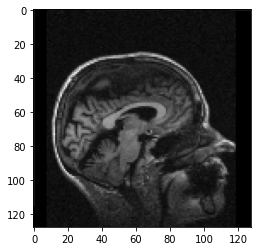

In [12]:
data = train_dataset.take(1)

images, labels = list(data)[0]
images = images.numpy()
labels = labels.numpy()
image = images[0]
label = labels[0]

print("Dimension of the MRI scan is:", image.shape)
classes = ['Nondemented', 'Demented']
print("Class:", classes[label])
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray");

Visualize montage of slices. Function from: https://keras.io/examples/vision/3D_image_classification/

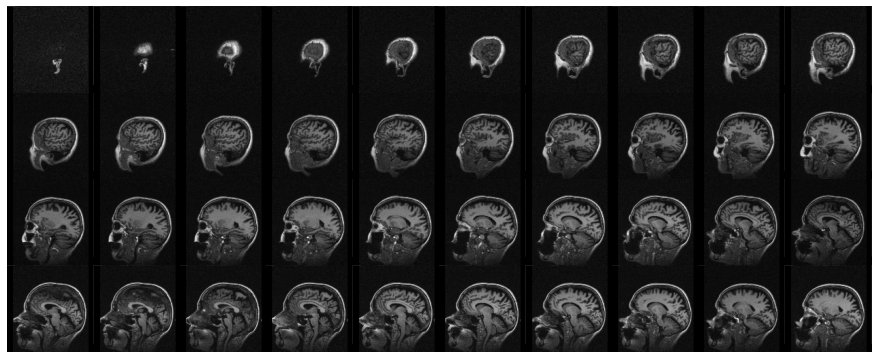

In [13]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the MRI scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

Visualize a few different slices

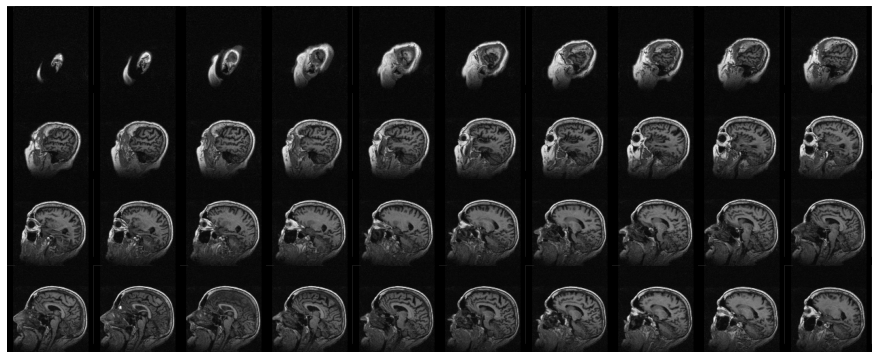

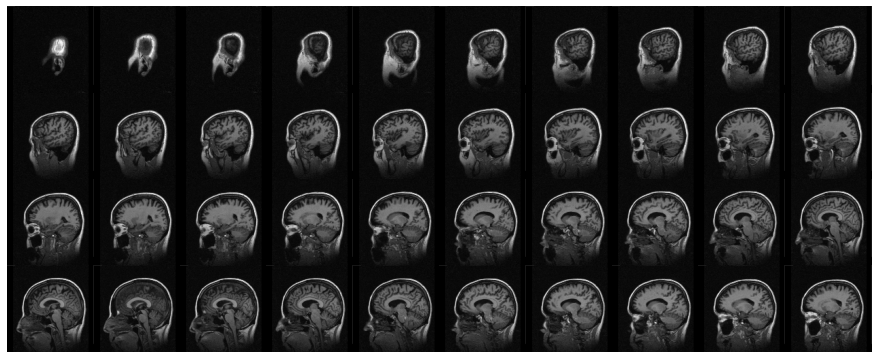

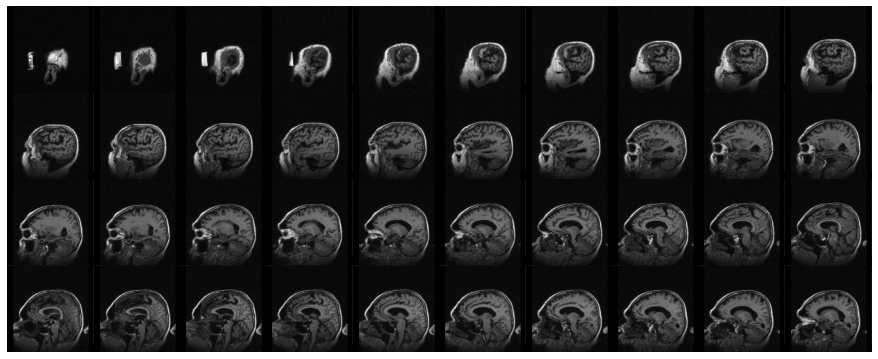

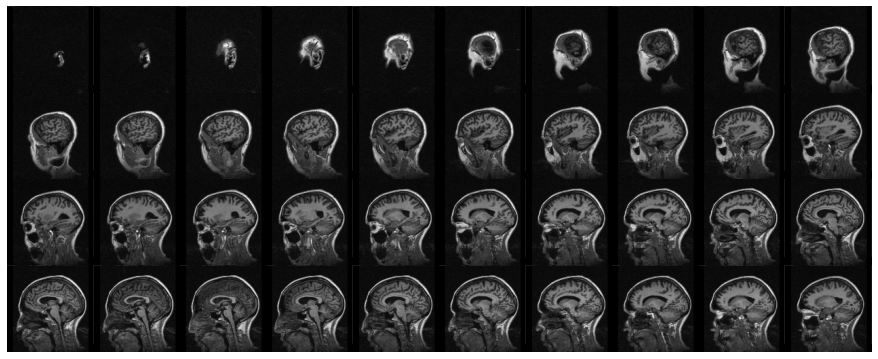

In [14]:
image1 = process_scan(x_train[17])
image2 = process_scan(x_train[40])
image3 = process_scan(x_val[4])
image4 = process_scan(x_val[19])

plot_slices(4, 10, 128, 128, image1[:, :, :40])
plot_slices(4, 10, 128, 128, image2[:, :, :40])
plot_slices(4, 10, 128, 128, image3[:, :, :40])
plot_slices(4, 10, 128, 128, image4[:, :, :40])

## Define model

In [15]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

## Train model

In [16]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "mri_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1, # show training progress
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
47/47 [==============================] - 268s 2s/step - loss: 0.7128 - acc: 0.4251 - val_loss: 0.7217 - val_acc: 0.4762
Epoch 2/100
47/47 [==============================] - 208s 2s/step - loss: 0.6794 - acc: 0.5731 - val_loss: 1.0379 - val_acc: 0.4762
Epoch 3/100
47/47 [==============================] - 205s 2s/step - loss: 0.6491 - acc: 0.6406 - val_loss: 1.2674 - val_acc: 0.4762
Epoch 4/100
47/47 [==============================] - 206s 2s/step - loss: 0.6642 - acc: 0.6285 - val_loss: 1.1262 - val_acc: 0.4762
Epoch 5/100
47/47 [==============================] - 201s 1s/step - loss: 0.6835 - acc: 0.5764 - val_loss: 0.8549 - val_acc: 0.4762
Epoch 6/100
47/47 [==============================] - 195s 1s/step - loss: 0.6380 - acc: 0.6358 - val_loss: 0.7449 - val_acc: 0.4762
Epoch 7/100
47/47 [==============================] - 194s 1s/step - loss: 0.5878 - acc: 0.7015 - val_loss: 1.3367 - val_acc: 0.4762
Epoch 8/100
47/47 [==============================] - 198s 1s/step - loss: 0.

## Visualize model performance

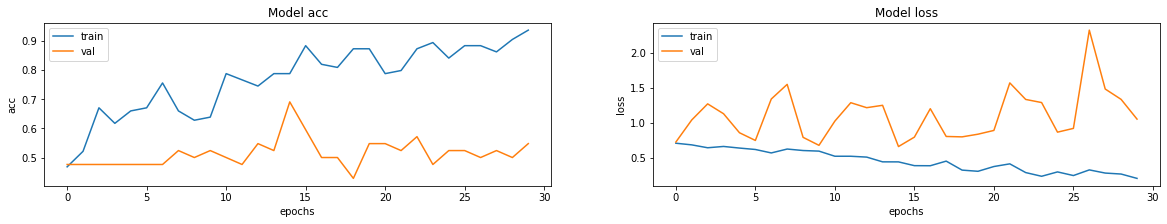

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on single scan

### Nondemented scan, class 0

Class = 0


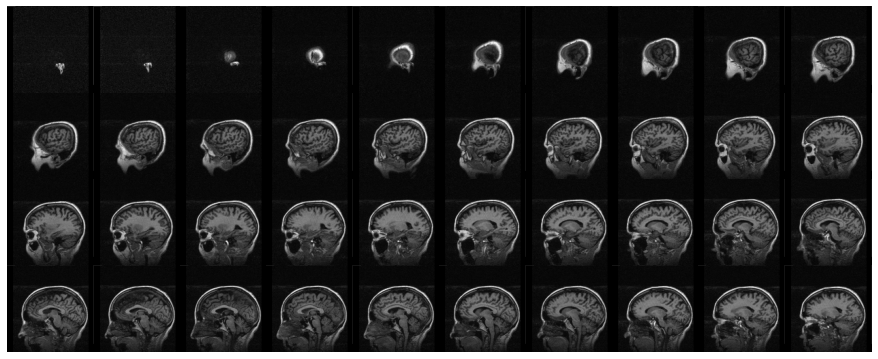

In [18]:
# load image from file
image = process_scan(x_val[5])
label = y_val[5]
print("Class =", label)
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [19]:
# Load best weights.
model.load_weights("mri_classification.h5")

# get image to appropriate shape
image = np.expand_dims(image, axis=0)
image.shape

# predict class of image
prediction = model.predict(image)
scores = [1 - prediction[0], prediction[0]]

class_names = ["nondemented", "demented"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

This model is 93.95 percent confident that MRI scan is nondemented
This model is 6.05 percent confident that MRI scan is demented


### Demented scan, class 1

Class = 1


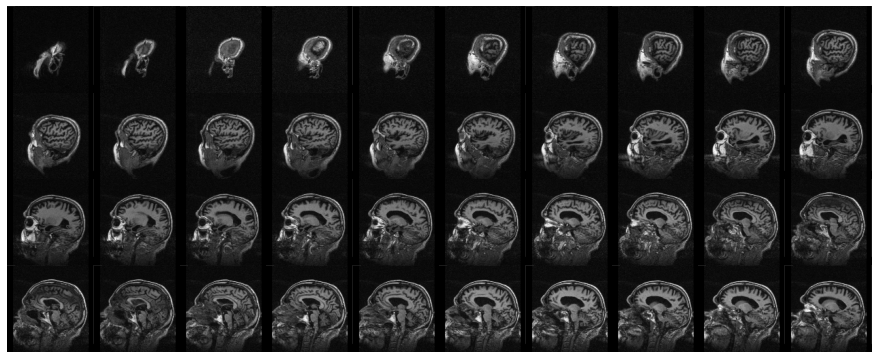

In [20]:
# load image from file
image = process_scan(x_val[35])
label = y_val[35]
print("Class =", label)
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [21]:
# get image to appropriate shape
image = np.expand_dims(image, axis=0)
image.shape

# predict class of image
prediction = model.predict(image)
scores = [1 - prediction[0], prediction[0]]

class_names = ["nondemented", "demented"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

This model is 13.58 percent confident that MRI scan is nondemented
This model is 86.42 percent confident that MRI scan is demented


## Download model to local machine

In [22]:
from google.colab import files
files.download('mri_classification.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>